# Neuron Modeling Project

In [50]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns



# Integrate and Fire Neuron Model

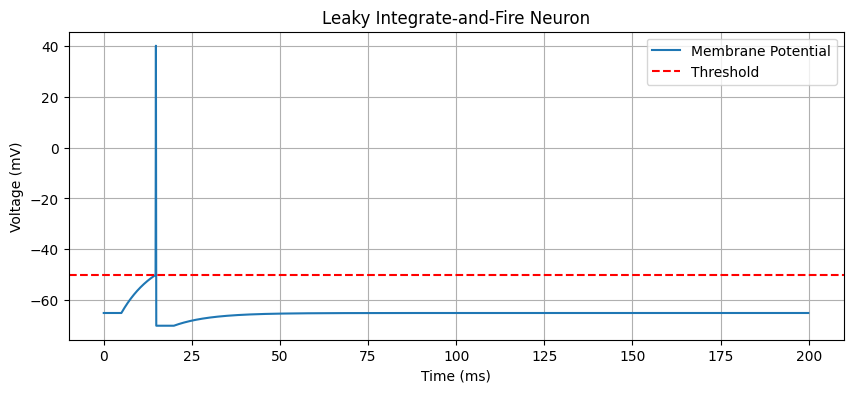

In [67]:

tau_m = 10.0      # Membrane time constant (in ms)
R_m = 1.0         # Membrane resistance (in MΩ)
V_rest = -65.0    # Resting potential (in mV)
V_th = -50.0      # Threshold potential (in mV)
V_reset = -70.0   # Reset potential after spike (in mV)
t_ref = 5.0       # Refractory period (in ms)

dt = 0.1  # Time step (in ms)
T = 200   # Total time (in ms)
time = np.arange(0, T, dt)


I = np.zeros(len(time))
I[50:150] = 24 # stimulus whihc is applied in specified period


V = np.full(len(time), V_rest)
spike_times = []
refractory_counter = 0


for t in range(1, len(time)):
    if refractory_counter > 0:
        V[t] = V_reset
        refractory_counter -= dt
    else:
        dV = (dt / tau_m) * (-(V[t-1] - V_rest) + R_m * I[t-1])
        V[t] = V[t-1] + dV
        if V[t] >= V_th:
            V[t] = 40.0  # spike
            spike_times.append(time[t])
            refractory_counter = t_ref


plt.figure(figsize=(10, 4))
plt.plot(time, V, label='Membrane Potential')
plt.axhline(V_th, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Leaky Integrate-and-Fire Neuron')
plt.legend()
plt.grid()
plt.show()


# Hodgkin-Huxley Single Neuron Model
The description, parameters and equations for the model are taken from:
- "Theoretical Neuroscience", Dayan and Abbot (2005)
- "Cellular Biophysics and Modeling", Smith (2019)
- "Models of the Mind", Lindsay (2022)


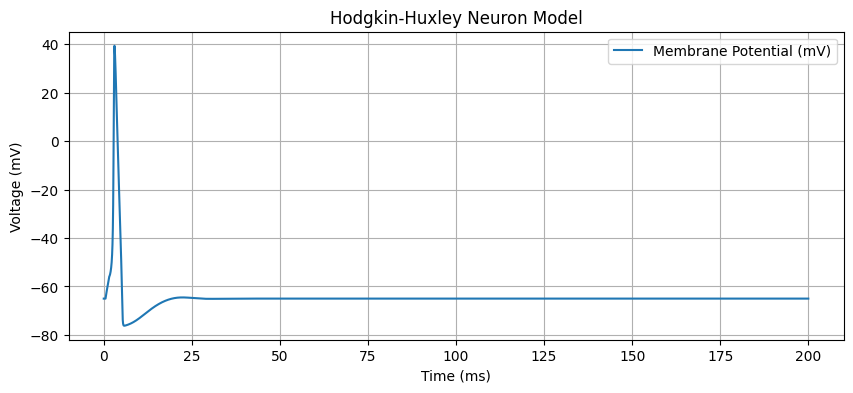

In [66]:
dt = 0.01   # in ms
T = 200.0    # total time in ms
time = np.arange(0, T, dt)


C_m = 1.0      # membrane capacitance, in uF/cm^2
g_Na = 120.0   # Sodium (Na) max conductance, in mS/cm^2
g_K = 36.0     # Potassium (K) max conductance, in mS/cm^2
g_L = 0.3      # Leak max conductance, in mS/cm^2

E_Na = 50.0    # Sodium equilibrium potential, in mV
E_K = -77.0    # Potassium equilibrium potential, in mV
E_L = -54.387  # Leak equilibrium potential, in mV


def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)

def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1 / (1 + np.exp(-(V + 35) / 10))



I_ext = np.zeros_like(time)
I_ext[50:150] = 10  # stimulus


V = np.full_like(time, -65.0)  # membrane potential
m = np.zeros_like(time)
h = np.zeros_like(time)
n = np.zeros_like(time)

# starting steady state
V[0] = -65
m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))


for t in range(1, len(time)):
    gNa = g_Na * m[t-1] ** 3 * h[t-1]
    gK  = g_K  * n[t-1] ** 4
    gL  = g_L

    # Currents
    INa = gNa * (V[t-1] - E_Na)
    IK  = gK  * (V[t-1] - E_K)
    IL  = gL  * (V[t-1] - E_L)

    # update
    dV = dt * (I_ext[t-1] - INa - IK - IL) / C_m
    V[t] = V[t-1] + dV

    # update gating
    m[t] = m[t-1] + dt * (alpha_m(V[t-1]) * (1 - m[t-1]) - beta_m(V[t-1]) * m[t-1])
    h[t] = h[t-1] + dt * (alpha_h(V[t-1]) * (1 - h[t-1]) - beta_h(V[t-1]) * h[t-1])
    n[t] = n[t-1] + dt * (alpha_n(V[t-1]) * (1 - n[t-1]) - beta_n(V[t-1]) * n[t-1])




plt.figure(figsize=(10, 4))
plt.plot(time, V, label='Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Neuron Model')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.legend()
plt.show()





---

# Hodgkin-Huxley Neural Network


## The Hodgkin-Huxley Equations:
$ C \frac{dV}{dt} = I_{app} - g_{Na}m^3h(V-E_{Na}) - g_Kn^4(V-E_K) - g_L(V-E_L) $

With...
|Symbol|Formula|
|---|---|
| $I_{Na_V}$ | $g_{Na}m^3h(V-E_{Na})$ |
| $I_{K_V}$ | $g_Kn^4(V-E_K)$ |
| $I_L$ | $g_L(V-E_L)$ |



$ \frac{dm}{dt} = -\frac{m-m_\infty(V)}{\tau_m(V)} $

$ \frac{dh}{dt} = -\frac{h-h_\infty(V)}{\tau_h(V)} $

$ \frac{dn}{dt} = -\frac{n-n_\infty(V)}{\tau_n(V)} $


In [61]:
class HHNeuron:
    def __init__(self, dt=0.01, C_m=1.0, neuron_id=0):
        self.id = neuron_id
        self.dt = dt
        self.C_m = C_m
        self.g_Na = 120.0
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0
        self.E_K = -77.0
        self.E_L = -54.387
        self.V = -65.0
        self.m = self.alpha_m(self.V) / (self.alpha_m(self.V) + self.beta_m(self.V))
        self.h = self.alpha_h(self.V) / (self.alpha_h(self.V) + self.beta_h(self.V))
        self.n = self.alpha_n(self.V) / (self.alpha_n(self.V) + self.beta_n(self.V))
        self.V_history = [self.V]
        self.spike_times = []
        self.last_V = self.V
        self.spike_threshold = 0.0
        self.t = 0.0


    def alpha_n(self, V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    def beta_n(self, V):  return 0.125 * np.exp(-(V + 65) / 80)
    def alpha_m(self, V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    def beta_m(self, V):  return 4 * np.exp(-(V + 65) / 18)
    def alpha_h(self, V): return 0.07 * np.exp(-(V + 65) / 20)
    def beta_h(self, V):  return 1  /  (1  +  np.exp(-(V + 35) / 10))


    def update(self, I_ext=0.0):
        gNa = self.g_Na * self.m ** 3 * self.h
        gK  = self.g_K * self.n ** 4
        gL  = self.g_L
        INa = gNa * (self.V - self.E_Na)
        IK  = gK  * (self.V - self.E_K)
        IL  = gL  * (self.V - self.E_L)
        dV = self.dt * (I_ext - INa - IK - IL) / self.C_m
        self.last_V = self.V
        self.V += dV
        self.m += self.dt * (self.alpha_m(self.V) * (1 - self.m) - self.beta_m(self.V) * self.m)
        self.h += self.dt * (self.alpha_h(self.V) * (1 - self.h) - self.beta_h(self.V) * self.h)
        self.n += self.dt * (self.alpha_n(self.V) * (1 - self.n) - self.beta_n(self.V) * self.n)

        if self.last_V < self.spike_threshold and self.V >= self.spike_threshold:
            self.spike_times.append(self.t)

        self.t += self.dt
        self.V_history.append(self.V)


    def get_voltage_trace(self):
        return np.array(self.V_history)
    

    def has_spiked(self):
        return self.last_V < self.spike_threshold and self.V >= self.spike_threshold


    def reset(self):
        self.__init__(self.dt, self.C_m, self.id)


In [70]:
class HHNetwork:
    def __init__(self, num_neurons, dt=0.01, T=50.0):
        self.dt = dt
        self.T = T
        self.steps = int(T / dt)
        self.time = np.arange(0, T + dt, dt)

        self.neurons = [HHNeuron(dt=dt, neuron_id=i) for i in range(num_neurons)]

        # Connectivity: weight[i, j] means (j -> i)
        self.weights = np.zeros((num_neurons, num_neurons))
        self.syn_delay = int(1.0 / dt)
        self.syn_duration = int(3.0 / dt)

        self.syn_queue = [np.zeros(self.steps + 100) for _ in self.neurons]
        self.I_ext = np.zeros((num_neurons, self.steps))


    def connect(self, source, target, weight):
        self.weights[target, source] = weight


    def set_external_current(self, neuron_idx, t_start, t_end, amplitude):
        self.I_ext[neuron_idx, int(t_start / self.dt):int(t_end / self.dt)] = amplitude


    def run(self):
        for t in range(self.steps):
            for i, neuron in enumerate(self.neurons):
                I = self.I_ext[i, t] + self.syn_queue[i][t]
                neuron.update(I_ext=I)

                if neuron.has_spiked():
                    for j, target_neuron in enumerate(self.neurons):
                        weight = self.weights[j, i]
                        if weight != 0:
                            for k in range(self.syn_delay, self.syn_delay + self.syn_duration):
                                if t + k < len(self.syn_queue[j]):
                                    self.syn_queue[j][t + k] += weight


    def draw_architecture(self, layer_assignment=None):
        G = nx.DiGraph()
        [G.add_node(i) for i, _ in enumerate(self.neurons)]

        # add all connections from weight matrxi
        for i in range(len(self.neurons)):
            for j in range(len(self.neurons)):
                if self.weights[j, i] != 0:
                    G.add_edge(i, j, weight=self.weights[j, i])

        # make layout look like typical neuroal network architecture
        if layer_assignment:
            pos = {}
            max_nodes = max(len(nodes) for nodes in layer_assignment.values())

            for layer, nodes in layer_assignment.items():
                n = len(nodes)
                y_coords = [((n - 1) / 2) - i for i in range(n)]  # centered Ys
                for node, y in zip(nodes, y_coords):
                    pos[node] = (layer, y)
        else:
            pos = nx.spring_layout(G)

        plt.figure(figsize=(8, 5))
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, arrows=True, arrowstyle='->', arrowsize=20)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{w:.0f}' for (i, j), w in edge_labels.items()})
        plt.title("Hodgkin-Huxley Neural Network Architecture")
        plt.axis('off')
        plt.show()


    def plot_results(self):
        plt.figure(figsize=(10, 6))

        for i, neuron in enumerate(self.neurons):
            plt.plot(self.time, neuron.get_voltage_trace(), label=f'Neuron {i}')
            
        plt.xlabel("Time (ms)")
        plt.ylabel("Membrane Potential (mV)")
        plt.title("Hodgkin-Huxley Network Dynamics")
        plt.legend()
        plt.grid(True)
        plt.show()




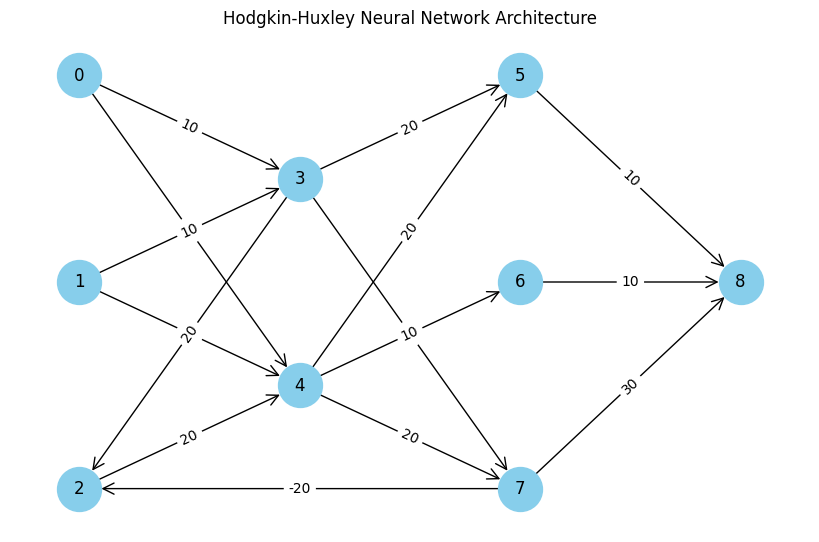

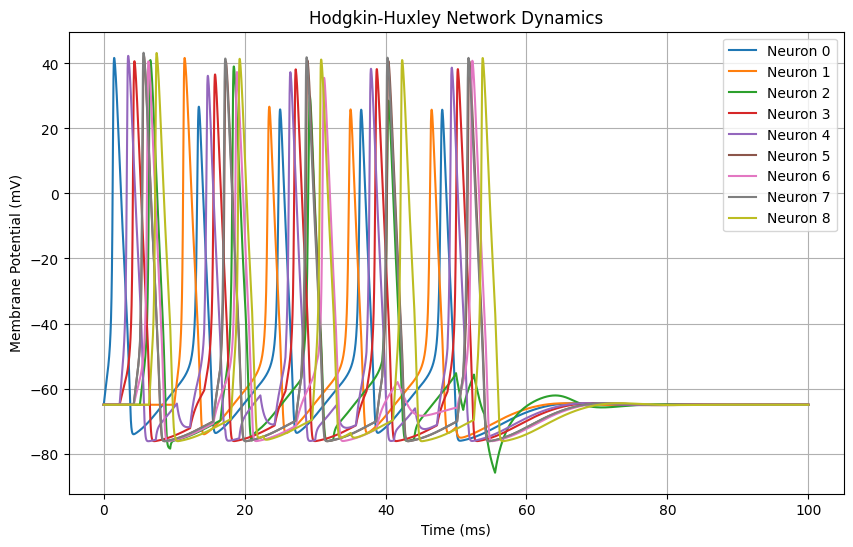

In [77]:
net = HHNetwork(num_neurons=9, dt=0.01, T=100.0)

# Layer 0 (input) -> Layer 1
net.connect(0, 3, 10.0)
net.connect(0, 4, 30.0)
net.connect(1, 3, 10.0)
net.connect(1, 4, 20.0)
net.connect(2, 4, 20.0)

# Layer 1 -> Layer 2 + Feedback to Layer 0
net.connect(3, 2, 20.0)
net.connect(3, 5, 20.0)
net.connect(3, 7, 40.0)
net.connect(4, 5, 20.0)
net.connect(4, 6, 10.0)
net.connect(4, 7, 20.0)

# Layer 2 -> Layer 3 + Feedback
net.connect(5, 8, 10.0)
net.connect(6, 8, 10.0)
net.connect(7, 8, 30.0)
net.connect(7, 2, -20.0)

# Input layer -> inital input
net.set_external_current(neuron_idx=0, t_start=0.0, t_end=50.0, amplitude=20.0)
net.set_external_current(neuron_idx=1, t_start=10.0, t_end=50.0, amplitude=20.0)
net.set_external_current(neuron_idx=2, t_start=20.0, t_end=50.0, amplitude=20.0)

# TODO:
# - create oscillations
# - look for some real biological data and compare it with model results
# - add learning -> hebbian learning rule?!
# - more realistic neuron -> multi-compartment model

# format: "layer: [list neurons in that layer]"
layer_assignment = {
    0: [0, 1, 2],   # Input layer
    1: [3, 4],      # Hidden
    2: [5, 6, 7],   # Hidden
    3: [8]          # Output
}

# Draw the network architecture
net.draw_architecture(layer_assignment)

# Run simulation
net.run()
net.plot_results()

